# **Histogram-based Gradient Boosting Classification Tree**

### **Why have this model been selected?**
- When testing models while elaborating the Exploratory Analysis of Data, we tried a Logistic Regression with missing values. However, this model does not handle missing values directly.

- Hence, an exception was triggered and the description explains that HistGradientBoosting Classifier could be tried to do so. 

**What is HistGradientBoostingClassifier?**
- It is a tree-based ensemble that builds models sequentially to minimize the loss function using gradient boosting.

- Instead of using all individual samples during training, it bins continous features into discrete intervals (histograms). Thus, the memory usage is reduced and the training is more rapid.

- Moreover, the scalability of this model is an advantage, because is useful for larger datasets. 

### **Import libraries and load data**

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Data
X_train_df = pd.read_csv('../data/gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('../data/gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

### **Modeling**

- Firstly to make the train-test split, it is important to stand out that it is used stratify parameter in order to ensure the distribution of target labels in the training and testing sets matches the distribution in the original dataset. This is important to consider when the target classes are imbalanced.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

- As we are treating a multi-output classification problem, the MultiOutputClassifier is a estimator designed for handling this situation. Each instance has multiple target labels. Therefore, it works by creating an independent classifier for each target.

In [3]:
# Set up the MultiOutputClassifier with Random Forest Regressor
multi_output_clf = MultiOutputClassifier(HistGradientBoostingClassifier(random_state=42))

#### **Cross Validation**

- The Cross Validation is put in comments because the best hyperparameters obtained were already passed directly to the model later in order to avoid running the GridSearchCV each time. In this way, larger running time is avoided.

- The **parameter grid** for tuning the hyperparameters of the Classifier with the corresponding Cross Validations is specified by:
    - learning_rate: Step size to update the model weights while training.
    - max_iter: maximum number of boosting iterations.
    - max_leaf_nodes: maximum number of leaf nodes per decision tree.
    - max_depth: maximum depth of each tree.
    - min_samples_leaf: minimum number of samples required to form a leaf node.
    

In [4]:
# # Let's do GridSearchCV
# # parameters grid
# param_grid = {
#     "estimator__learning_rate" : [0.05, 0.1, 0.2, 0.3],
#     "estimator__max_iter" : [100, 200, 300],
#     "estimator__max_leaf_nodes" : [31, 63, 127],
#     "estimator__max_depth" : [None, 5, 10, 20, 30],
#     "estimator__min_samples_leaf" : [20, 50, 100],
# }

-   Now, GridSearchCV is used to optimize the hyperparameters using the MultiOutputClassifier and the parameter grid already defined. 
    - 5-fold cross validation
    - n_jobs: -1 (all available CPU cores to use)
    - verbose: Verbositiy of 2 to provide detailed updates on the progress.

In [5]:
# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=multi_output_clf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters from Grid Search:", grid_search.best_params_)
# print("Best Score from Grid Search:", grid_search.best_score_)

# # Evaluate on the test set
# y_pred_grid = grid_search.predict(X_test)
# mse_grid = mean_squared_error(y_test, y_pred_grid)
# acc_grid = accuracy_score(y_test, y_pred_grid)
# print(f"Mean Squared Error (Grid Search): {mse_grid}")
# print(f"Accuracy (Grid Search): {acc_grid}")

- Model with the corresponding best hyperparameters obtained after executing GridSearchCV.

In [6]:
estimators = MultiOutputClassifier(
    estimator = HistGradientBoostingClassifier(
        learning_rate = 0.05, 
        max_depth = 5,
        max_iter = 200,
        max_leaf_nodes = 31,
        min_samples_leaf = 100
    )
)

- The model is fitted.

In [7]:
estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=HistGradientBoostingClassifier(learning_rate=0.05,
                                                               max_depth=5,
                                                               max_iter=200,
                                                               min_samples_leaf=100))

- The method predict_proba is utilized to return prediction probabilities for each class of each output.

In [8]:
preds = estimators.predict_proba(X_test)
preds

[array([[0.9864502 , 0.0135498 ],
        [0.60999621, 0.39000379],
        [0.93940605, 0.06059395],
        ...,
        [0.968722  , 0.031278  ],
        [0.6187604 , 0.3812396 ],
        [0.69732875, 0.30267125]]),
 array([[0.70934388, 0.29065612],
        [0.23098024, 0.76901976],
        [0.90539356, 0.09460644],
        ...,
        [0.89097321, 0.10902679],
        [0.33486086, 0.66513914],
        [0.46534065, 0.53465935]])]

- A dataframe is created with the predictions obtained

In [9]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.013550,0.290656
1215,0.390004,0.769020
10540,0.060594,0.094606
7407,0.194634,0.240023
14697,0.117521,0.211515


### **RESULTS: ROC CURVE**

- Definition of a method to plot roc curves easily.

In [10]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

- Plot the roc curves.

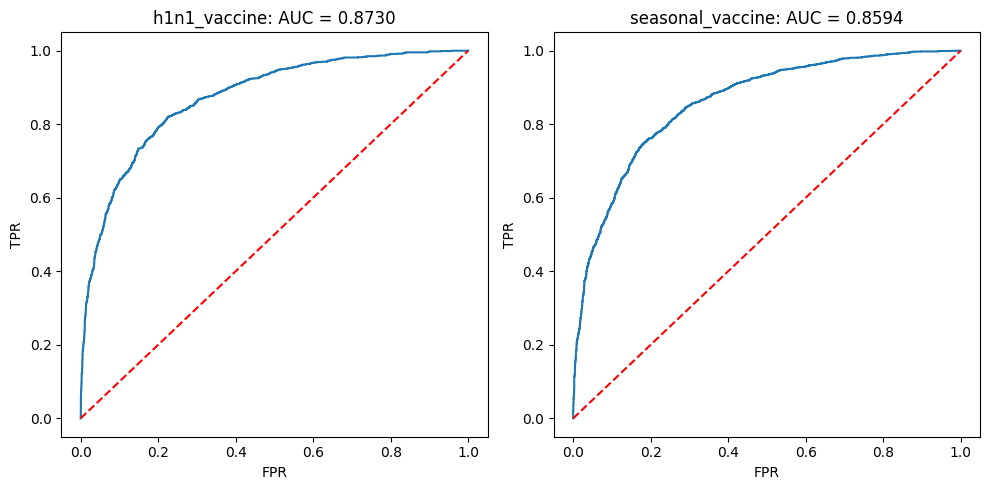

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

- On the one hand, in the **left plot for h1n1_vaccine**, the classifier has a strong ability to distinguish between positive and negative classes for this label, as AUC = 0.8714.
    - The curve is maintained above the red line significantly. This indicates that the model performs well and there is no random guessing.
    - Besides, there is a level where the model achieves a high TPR and a low FPR.

- On the other hand, in the **right plot for seasonal_vaccine**, AUC = 0.8615. It indicates a strong performance as well distinguishing between positive and negative classes..
    - The curve is also significantly above the red line. Indicating a good discrimination between clases.
    - And the slope reflects a similar performance as the h1n1_vaccine.

### **RESULTS: CONFUSION MATRIX**

- The confusion matrix is a performance evaluation tool for the predictions of the model. It requires the predictions to be binary, therefore, now, the prediction method is used instead.

In [12]:
preds_no_proba = estimators.predict(X_test)
preds

[array([[0.9864502 , 0.0135498 ],
        [0.60999621, 0.39000379],
        [0.93940605, 0.06059395],
        ...,
        [0.968722  , 0.031278  ],
        [0.6187604 , 0.3812396 ],
        [0.69732875, 0.30267125]]),
 array([[0.70934388, 0.29065612],
        [0.23098024, 0.76901976],
        [0.90539356, 0.09460644],
        ...,
        [0.89097321, 0.10902679],
        [0.33486086, 0.66513914],
        [0.46534065, 0.53465935]])]

- Save the predictions obtained in a dataframe.

In [13]:
y_preds_no_proba = pd.DataFrame(
    {
        'h1n1_vaccine': preds_no_proba[:, 0],
        'seasonal_vaccine': preds_no_proba[:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds_no_proba.shape)
y_preds_no_proba.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0,0
1215,0,1
10540,0,0
7407,0,0
14697,0,0


- The confusion Matrix has the following structure:
    - TP FN 
    - FP TN

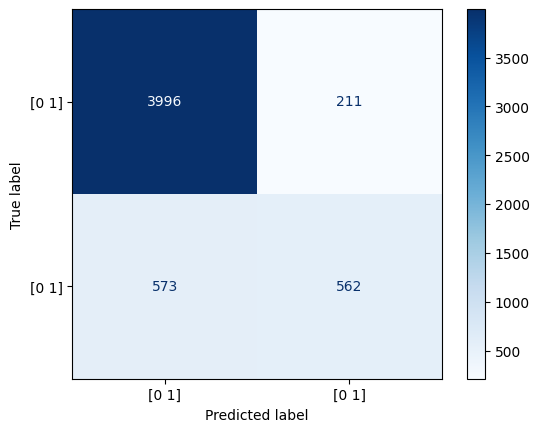

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4207
           1       0.73      0.50      0.59      1135

    accuracy                           0.85      5342
   macro avg       0.80      0.72      0.75      5342
weighted avg       0.84      0.85      0.84      5342



In [14]:
# h1n1_vaccine
cm = metrics.confusion_matrix(y_test['h1n1_vaccine'], y_preds_no_proba['h1n1_vaccine'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test['h1n1_vaccine'], y_preds_no_proba['h1n1_vaccine']))

**CONFUSION MATRIX FOR h1n1_vaccine**
- The model correctly classified 85% of the total samples. However, this accuracy can be misleading in imbalanced datasets.
- Regarding precision, recall and f1-score, for class 0, the majority of samples were correctly classified and identified. However, for classs 1, the model struggles to balance precision and recall. 
- There are significantly more samples in class 0 compared to class 1. This imbalance impacts the model to predict class 1 accurately (lower recall).

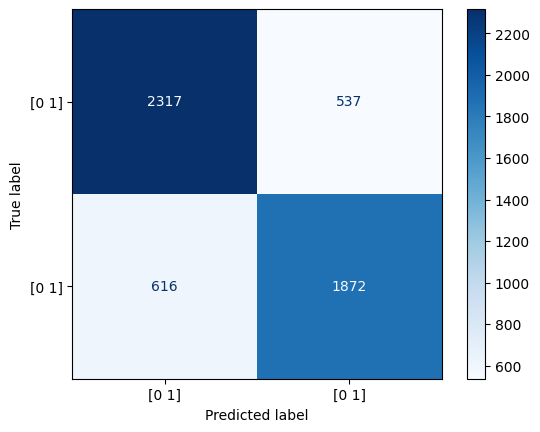

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2854
           1       0.78      0.75      0.76      2488

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



In [15]:
cm = metrics.confusion_matrix(y_test['seasonal_vaccine'], y_preds_no_proba['seasonal_vaccine'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test['seasonal_vaccine'], y_preds_no_proba['seasonal_vaccine']))

**CONFUSION MATRIX FOR seasonal_vaccine**
- The model correctly classified 78% of the total samples.In this case, there is no imbalance (support in class 0: 2854 and suppor in class 1: 2488)
- Regarding precision, recall and f1-score, for class 0 and class 1, there are similar results. The model correctly identify around 80% of the actual classes. This suggests the model performs consistently for the two classes.
- However, there are around more than 1000 samples incorrectly classified. So, the model has a slight struggle differentiating between the twoo clases. 
- The overall metrics indicate the model works well for both classes (good dataset distribution).



### **FIT AND PREDICT RESULTS FOR COMPETITION UPLOAD**

-  The model is trained for the competition using training_set_labels_df.

In [16]:
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)
preds

[array([[0.84946276, 0.15053724],
        [0.95166836, 0.04833164],
        [0.82314546, 0.17685454],
        ...,
        [0.77489337, 0.22510663],
        [0.98268693, 0.01731307],
        [0.38985666, 0.61014334]]),
 array([[0.79524543, 0.20475457],
        [0.97266995, 0.02733005],
        [0.2747726 , 0.7252274 ],
        ...,
        [0.77647285, 0.22352715],
        [0.73707035, 0.26292965],
        [0.3231037 , 0.6768963 ]])]

- A dataframe is created with the predictions.

In [17]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.150537,0.204755
26708,0.048332,0.027330
26709,0.176855,0.725227
26710,0.713291,0.889737
26711,0.262671,0.549828


- Export the CSV to upload to Driven Data. **This gives our AUC best score: 0.8592**

In [18]:
y_preds.to_csv('../results/pred_hist_gradient_boosting.csv', index = True)